##### After initial solo attempt, this has been strongly influenced by <br> *https://techrando.com/2019/07/03/how-to-automate-decline-curve-analysis-dca-in-python-using-scipys-optimize-curve_fit-function/*

In [3]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [4]:
def hyperbolic_decline(t,qi,b,di):
    return qi/((1.0+b*di*t)**(1.0/b))

In [5]:
def exponential_decline(t,qi,di):
    return qi*np.exp(-di*t)

In [8]:
def get_max_initial_production(df,number_of_months,oil_volume_col):
    df = df.sort_index()
    df_initial_production = df.head(number_of_months)
    return df_initial_production[oil_volume_col].max()

In [7]:
well_8a = pd.read_excel('Data/8a.xlsx',parse_dates=True,index_col='Unit Name/Test Date')
well_8a.head()

,Completion Prop Num,Test Oil Vol (bbl),Test Gas Vol (MCF),Test Water Vol (bbl)
Unit Name/Test Date,,,,
2018-09-16,W1CE7C2E2I,5,NaN,392
2018-09-17,W1CE7C2E2I,15,NaN,327
2018-09-20,W1CE7C2E2I,40,NaN,379
2018-09-22,W1CE7C2E2I,50,NaN,368
2018-09-24,W1CE7C2E2I,56,NaN,352


In [11]:
import datetime as dt

# Convert date to a numerical number that can be graphed
def convert_datetime_to_int(date):
    return((date - dt.datetime(1970,1,1)).days)


# TEST to see that it works
convert_datetime_to_int(well_8a.index[0])

17790

In [13]:
# Map it to the entire DF
well_8a['Days_Online'] = well_8a.index.map(convert_datetime_to_int)
well_8a.head(5)

,Completion Prop Num,Test Oil Vol (bbl),Test Gas Vol (MCF),Test Water Vol (bbl),Days_Online
Unit Name/Test Date,,,,,
2018-09-16,W1CE7C2E2I,5,NaN,392,17790
2018-09-17,W1CE7C2E2I,15,NaN,327,17791
2018-09-20,W1CE7C2E2I,40,NaN,379,17794
2018-09-22,W1CE7C2E2I,50,NaN,368,17796
2018-09-24,W1CE7C2E2I,56,NaN,352,17798


In [15]:
# Time-zero the day_online
well_8a['Days_Online'] = well_8a['Days_Online'] - well_8a["Days_Online"].min()
well_8a.head(5)

,Completion Prop Num,Test Oil Vol (bbl),Test Gas Vol (MCF),Test Water Vol (bbl),Days_Online
Unit Name/Test Date,,,,,
2018-09-16,W1CE7C2E2I,5,NaN,392,0
2018-09-17,W1CE7C2E2I,15,NaN,327,1
2018-09-20,W1CE7C2E2I,40,NaN,379,4
2018-09-22,W1CE7C2E2I,50,NaN,368,6
2018-09-24,W1CE7C2E2I,56,NaN,352,8


In [10]:
qi = get_max_initial_production(well_8a, 10,"Test Oil Vol (bbl)")
qi

66

In [16]:
#Exponential curve fit the data to get best fit equation
popt_exp, pcov_exp = curve_fit(exponential_decline, well_8a['Days_Online'], well_8a["Test Oil Vol (bbl)"],bounds=(0, [qi,20]))
print(f'Exponential Fit Curve-fitted Variables: qi={popt_exp[0]:.2f}, di={popt_exp[1]:.2f}')


Exponential Fit Curve-fitted Variables: qi=40.40, di=0.00


In [19]:
# Hyperbolic curve fit the data to get best fit equation
popt_hyp, pcov_hyp = curve_fit(hyperbolic_decline, well_8a['Days_Online'], well_8a["Test Oil Vol (bbl)"],bounds=(0, [qi,2,20]))
print(f'Hyperbolic Fit Curve-fitted Variables: qi={popt_hyp[0]:.2f}, b={popt_hyp[1]:.2f} , and di={popt_hyp[2]:.2f}')

Hyperbolic Fit Curve-fitted Variables: qi=49.33, b=2.00 , and di=0.01


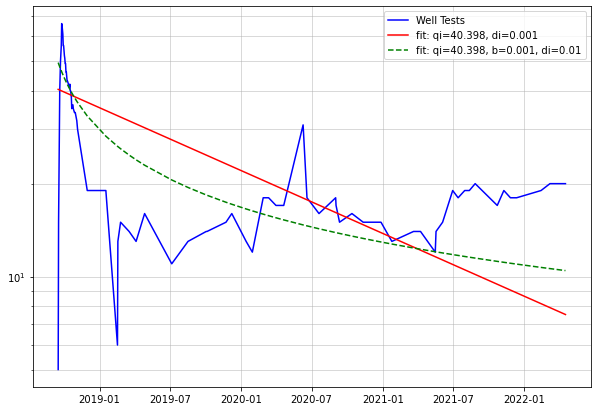

In [20]:
plt.figure(figsize=(10,7))
plt.plot(well_8a.index, well_8a['Test Oil Vol (bbl)'],'b-',label='Well Tests')
plt.plot(well_8a.index, exponential_decline(well_8a['Days_Online'],*popt_exp), 'r-', label= f"fit: qi={popt_exp[0]:.3f}, di={popt_exp[1]:.3f}")
plt.plot(well_8a.index, hyperbolic_decline(well_8a['Days_Online'],*popt_hyp), 'g--', label= f"fit: qi={popt_exp[0]:.3f}, b={popt_exp[1]:.3f}, di={popt_hyp[2]:.2f}")
#plt.plot(xdata, func(xdata,*popt2), 'g--', label= f"fit: a={popt2[0]:.3f}, b={popt2[1]:.3f}, c={popt2[2]:.3f}")
plt.legend()
plt.grid(True, which= "both", alpha=0.6)
plt.yscale("log")

plt.show()